<a href="https://colab.research.google.com/github/gChagasGit/CompiladoLUA/blob/main/Notebook/Unet_train_segmented_vessels_primario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Jan 13 19:21:49 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:81:00.0 Off |                  N/A |
| 39%   50C    P8    30W / 250W |     60MiB / 12061MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import cv2
import os
from collections import OrderedDict
from torch.nn import init
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [145]:
# Diretórios do dataset
DATA_DIR = "/home/gchagas/YoloV8_Seg/datasets/microscopic"

PATH_IMAGE = 'images'
PATH_LABEL =  'labels'

h = (1936 // 32) * 8
w = (2584 // 32) * 8

# Hiperparâmetros
BATCH_SIZE = 4
# IMG_SIZE = (608, 608)
IMG_SIZE = (w, h)
EPOCHS = 150
NUM_CLASSES = 1  # Segmentação binária: fundo vs. objeto

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

num_devices = torch.cuda.device_count()
print(f"Número de GPUs disponíveis: {num_devices}")

# DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"DEVICE: {DEVICE}")

if DEVICE.type == 'cpu':
  print("Atenção: GPU não disponível.")


Número de GPUs disponíveis: 1
DEVICE: cuda


In [101]:
def yolo_to_mask(yolo_file, img_size=(608, 608)):
    width, height = img_size
    mask = np.zeros((height, width), dtype=np.uint8)

    with open(yolo_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 4 or (len(parts) - 1) % 2 != 0:
                continue  # Pula linhas inválidas

            coords = [float(p) for p in parts[1:]]
            points = np.array([
                [int(x * width), int(y * height)] for x, y in zip(coords[::2], coords[1::2])
            ])

            cv2.fillPoly(mask, [points], 255)

    # Salva a máscara
    # cv2.imwrite(output_path, mask)
    return mask

In [5]:
class SegmentationDataset():
    def __init__(self, image_dir, mask_dir, mode='Test', transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mode = mode
        self.images = os.listdir(os.path.join(image_dir, self.mode))
        print(self.images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.mode, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.mode, self.images[idx])

        mask_path = mask_path.replace('.png', '.txt')

        # # Carregando a imagem
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Redimensionando a imagem
        image = cv2.resize(image, IMG_SIZE)

        mask = yolo_to_mask(mask_path, img_size=IMG_SIZE)

        # # Redimensionando a máscara para o tamanho da imagem
        mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
        mask = np.expand_dims(mask, axis=-1)  # Adicionando a dimensão extra para o canal

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        #     mask = torch.from_numpy(mask).unsqueeze(0)

        # image = torch.flip(image.permute(1, 2, 0), dims=[-1]) # dims=[-1] -> De BGR para RGB

        return image, mask

# Transformações para normalizar os dados
transform = transforms.Compose([
    # transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
])


In [6]:
def conv3x3(in_channels, out_channels, stride=1,
            padding=1, bias=True, groups=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=padding,
        bias=bias,
        groups=groups)

def upconv2x2(in_channels, out_channels, mode='transpose'):
    if mode == 'transpose':
        return nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=2,
            stride=2)
    else:
        # out_channels is always going to be the same
        # as in_channels
        return nn.Sequential(
            nn.Upsample(mode='bilinear', scale_factor=2),
            conv1x1(in_channels, out_channels))

def conv1x1(in_channels, out_channels, groups=1):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=1,
        groups=groups,
        stride=1)

In [7]:
class DownConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 MaxPool.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling

        self.conv1 = conv3x3(self.in_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)

        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        if self.pooling:
            x = self.pool(x)
        return x, before_pool


class UpConv(nn.Module):
    """
    A helper Module that performs 2 convolutions and 1 UpConvolution.
    A ReLU activation follows each convolution.
    """
    def __init__(self, in_channels, out_channels,
                 merge_mode='concat', up_mode='transpose'):
        super(UpConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.merge_mode = merge_mode
        self.up_mode = up_mode

        self.upconv = upconv2x2(self.in_channels, self.out_channels,
            mode=self.up_mode)

        if self.merge_mode == 'concat':
            self.conv1 = conv3x3(
                2*self.out_channels, self.out_channels)
        else:
            # num of input channels to conv2 is same
            self.conv1 = conv3x3(self.out_channels, self.out_channels)
        self.conv2 = conv3x3(self.out_channels, self.out_channels)


    def forward(self, from_down, from_up):
        """ Forward pass
        Arguments:
            from_down: tensor from the encoder pathway
            from_up: upconv'd tensor from the decoder pathway
        """
        from_up = self.upconv(from_up)
        if self.merge_mode == 'concat':
            x = torch.cat((from_up, from_down), 1)
        else:
            x = from_up + from_down
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

In [8]:
class UNet(nn.Module):
    """ `UNet` class is based on https://arxiv.org/abs/1505.04597

    The U-Net is a convolutional encoder-decoder neural network.
    Contextual spatial information (from the decoding,
    expansive pathway) about an input tensor is merged with
    information representing the localization of details
    (from the encoding, compressive pathway).

    Modifications to the original paper:
    (1) padding is used in 3x3 convolutions to prevent loss
        of border pixels
    (2) merging outputs does not require cropping due to (1)
    (3) residual connections can be used by specifying
        UNet(merge_mode='add')
    (4) if non-parametric upsampling is used in the decoder
        pathway (specified by upmode='upsample'), then an
        additional 1x1 2d convolution occurs after upsampling
        to reduce channel dimensionality by a factor of 2.
        This channel halving happens with the convolution in
        the tranpose convolution (specified by upmode='transpose')
    """

    def __init__(self, num_classes, in_channels=3, depth=5,
                 start_filts=64, up_mode='transpose',
                 merge_mode='concat'):
        """
        Arguments:
            in_channels: int, number of channels in the input tensor.
                Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            start_filts: int, number of convolutional filters for the
                first conv.
            up_mode: string, type of upconvolution. Choices: 'transpose'
                for transpose convolution or 'upsample' for nearest neighbour
                upsampling.
        """
        super(UNet, self).__init__()

        if up_mode in ('transpose', 'upsample'):
            self.up_mode = up_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for "
                             "upsampling. Only \"transpose\" and "
                             "\"upsample\" are allowed.".format(up_mode))

        if merge_mode in ('concat', 'add'):
            self.merge_mode = merge_mode
        else:
            raise ValueError("\"{}\" is not a valid mode for"
                             "merging up and down paths. "
                             "Only \"concat\" and "
                             "\"add\" are allowed.".format(up_mode))

        # NOTE: up_mode 'upsample' is incompatible with merge_mode 'add'
        if self.up_mode == 'upsample' and self.merge_mode == 'add':
            raise ValueError("up_mode \"upsample\" is incompatible "
                             "with merge_mode \"add\" at the moment "
                             "because it doesn't make sense to use "
                             "nearest neighbour to reduce "
                             "depth channels (by half).")

        self.num_classes = num_classes
        self.in_channels = in_channels
        self.start_filts = start_filts
        self.depth = depth

        self.down_convs = []
        self.up_convs = []

        # create the encoder pathway and add to a list
        for i in range(depth):
            ins = self.in_channels if i == 0 else outs
            outs = self.start_filts*(2**i)
            pooling = True if i < depth-1 else False

            down_conv = DownConv(ins, outs, pooling=pooling)
            self.down_convs.append(down_conv)

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        for i in range(depth-1):
            ins = outs
            outs = ins // 2
            up_conv = UpConv(ins, outs, up_mode=up_mode,
                merge_mode=merge_mode)
            self.up_convs.append(up_conv)

        self.conv_final = conv1x1(outs, self.num_classes)

        # add the list of modules to current module
        self.down_convs = nn.ModuleList(self.down_convs)
        self.up_convs = nn.ModuleList(self.up_convs)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            init.xavier_normal(m.weight)
            init.constant(m.bias, 0)


    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)


    def forward(self, x):
        encoder_outs = []

        # encoder pathway, save outputs for merging
        for i, module in enumerate(self.down_convs):
            x, before_pool = module(x)
            encoder_outs.append(before_pool)

        for i, module in enumerate(self.up_convs):
            before_pool = encoder_outs[-(i+2)]
            x = module(before_pool, x)

        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss is your training script,
        # as this module includes a softmax already.
        x = self.conv_final(x)
        return x

In [120]:
# def train(mode='Train'):

#   print(DEVICE)

#   # Criar DataLoader
#   train_dataset = SegmentationDataset(PATH_IMAGES, PATH_LABELS, mode=mode, transform=transform)
#   train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

#   # Inicializar o modelo
#   model = UNet(NUM_CLASSES, in_channels=3).to(DEVICE)
#   criterion = nn.BCEWithLogitsLoss()  # Loss para segmentação binária
#   optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

#   # Loop de treino
#   for epoch in range(EPOCHS):
#       model.train()
#       running_loss = 0.0

#       for images, masks in train_loader:
#           images, masks = images.to(DEVICE), masks.to(DEVICE)
#           optimizer.zero_grad()

#           outputs = model(images)
#           loss = criterion(outputs, masks)
#           loss.backward()
#           optimizer.step()

#           running_loss += loss.item()

#       print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.4f}")

#   return model


In [140]:
def train(mode='Train'):

    print(DEVICE)

    # Criar DataLoader
    train_dataset = SegmentationDataset(PATH_IMAGES, PATH_LABELS, mode=mode, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Inicializar o modelo
    model = UNet(NUM_CLASSES, in_channels=3).to(DEVICE)
    criterion = nn.BCEWithLogitsLoss()  # Loss para segmentação binária
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Inicializar variáveis para monitorar o melhor modelo
    best_loss = float('inf')  # Começa com valor infinito, para garantir que qualquer perda será menor
    best_model_wts = None
    best_epoch = 0
    epochs_without_improvement = 0

    # Loop de treino
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss:.4f}")

        # Verificar se houve melhoria na perda
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = model.state_dict()
            best_epoch = epoch+1
            epochs_without_improvement = 0  # Resetar o contador
        else:
            epochs_without_improvement += 1

        # Interromper o treinamento se não houver melhoria por 30 épocas consecutivas
        if epochs_without_improvement >= 30:
            print("Não houve melhoria por 30 épocas consecutivas. Interrompendo o treinamento.")
            break

    # Carregar os pesos do melhor modelo
    model.load_state_dict(best_model_wts)
    print("Melhor modelo carregado: EPOCH " + str(best_epoch))

    return model


In [ ]:
PATH_IMAGES = os.path.join(DATA_DIR, PATH_IMAGE)
PATH_LABELS = os.path.join(DATA_DIR, PATH_LABEL)

# print(PATH_IMAGES)
# print(PATH_LABELS)

MODE='Train'

if __name__ == "__main__":
    torch.cuda.empty_cache()
    model = train(MODE)
    print("-- FINAL TREINO --")

    # """
    # testing
    # """
    # model = UNet(3, depth=5, merge_mode='concat')
    # x = Variable(torch.FloatTensor(np.random.random((1, 3, 320, 320))))
    # out = model(x)
    # loss = torch.sum(out)
    # loss.backward()

cuda
['57.png', '29.png', '4.png', '33.png', '7.png', '1.png', '11.png', '68.png', '14.png', '26.png', '56.png', '38.png', '54.png', '42.png', '19.png', '47.png', '52.png', '69.png', '51.png', '37.png', '6.png', '5.png', '45.png', '62.png', '64.png', '23.png', '40.png', '43.png', '15.png', '60.png', '30.png', '22.png', '10.png', '34.png', '53.png', '35.png', '55.png', '70.png', '28.png', '20.png', '36.png', '66.png', '13.png', '61.png', '67.png', '8.png', '12.png', '50.png', '63.png', '58.png', '16.png', '24.png', '39.png', '9.png', '65.png', '48.png', '21.png', '2.png', '46.png', '17.png', '32.png', '49.png', '27.png', '31.png', '25.png', '59.png', '44.png', '3.png', '18.png', '41.png']


/tmp/ipykernel_14398/3717543393.py:100: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  init.xavier_normal(m.weight)
/tmp/ipykernel_14398/3717543393.py:101: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  init.constant(m.bias, 0)


Epoch [1/150], Loss: 1.9215
Epoch [2/150], Loss: 0.4004
Epoch [3/150], Loss: 0.1674
Epoch [4/150], Loss: 0.1163
Epoch [5/150], Loss: 0.1139
Epoch [6/150], Loss: 0.1040
Epoch [7/150], Loss: 0.1103
Epoch [8/150], Loss: 0.1000
Epoch [9/150], Loss: 0.0840


In [59]:
# def mean_iou(y_true, y_pred):
#     """
#     Calcula o Mean IoU para uma única imagem.
#     :param y_true: Tensor de verdadeiros (H, W), valores binários (0 ou 1).
#     :param y_pred: Tensor de predições (H, W), valores binários (0 ou 1).
#     :return: Valor IoU médio (float).
#     """
#     # Interseção: pixels preditos e verdadeiros iguais a 1
#     intersection = torch.logical_and(y_true == 1, y_pred == 1).sum().item()

#     # União: soma dos pixels preditos ou verdadeiros igual a 1
#     union = torch.logical_or(y_true == 1, y_pred == 1).sum().item()

#     # Evitar divisão por zero
#     if union == 0:
#         return 1.0  # Se não há região, considerar IoU perfeito
#     else:
#         return (intersection / union)

In [108]:
def mean_iou(y_true, y_pred):
    """
    Calcula o IoU (Intersection over Union) para uma única imagem binária.

    Args:
        y_true: Tensor de verdadeiros (H, W), valores binários (0 ou 1).
        y_pred: Tensor de predições (H, W), valores binários (0 ou 1).

    Returns:
        Valor IoU (float).
    """
    # Verificar se as dimensões das máscaras são iguais
    if y_true.shape != y_pred.shape:
        # Se não forem, fazer o resize de y_pred para o tamanho de y_true
        y_pred = F.interpolate(y_pred.unsqueeze(0).unsqueeze(0), size=y_true.shape, mode='nearest').squeeze()

    # Calcular a interseção e a união
    intersection = torch.logical_and(y_true, y_pred).sum()
    union = torch.logical_or(y_true, y_pred).sum()

    # Evitar divisão por zero
    iou = torch.where(union == 0, torch.tensor(1.0, dtype=torch.float32), intersection / union)
    return iou.item()


Mean IoU: 0.7753


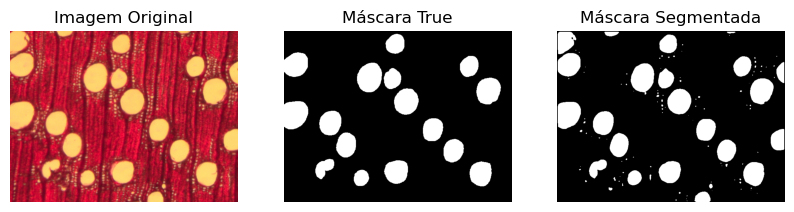

In [141]:
# Avaliação do modelo
model.eval() # 'model' is now assigned with the trained model.
with torch.no_grad():
    # 1. Carregar e preparar a imagem de teste
    test_image = cv2.imread("/home/gchagas/YoloV8_Seg/datasets/microscopic/images/Validation/78.png")
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)  # Converter BGR para RGB
    test_image = cv2.resize(test_image, IMG_SIZE)  # Redimensionar

    # 2. Aplicar a transformação e adicionar dimensão de batch
    input_tensor = transform(test_image).unsqueeze(0).to(DEVICE) # Changed 'device' to 'DEVICE'

    # 3. Gerar a previsão
    output = model(input_tensor)
    predicted_mask = torch.sigmoid(output).squeeze().cpu().numpy()

    # 4. Binarizar a máscara
    binary_mask = (predicted_mask > 0.5).astype("uint8")
    # Converter binary_mask para tensor
    binary_mask = torch.tensor(binary_mask, dtype=torch.float32)

    # 5. Verdadeiros rótulos (y_true) devem ser carregados para comparação
    # Substitua 'load_ground_truth' pela função que carrega a máscara verdadeira
    true_mask = yolo_to_mask("/home/gchagas/YoloV8_Seg/datasets/microscopic/labels/Validation/78.txt", IMG_SIZE)  # Deve ser um tensor com valores 0 ou 1
    true_mask = torch.tensor(true_mask, dtype=torch.float32)

    # 6. Calcular Mean IoU
    iou = mean_iou(true_mask, binary_mask)
    print(f"Mean IoU: {iou:.4f}")

    # 7. Exibir a imagem original e a máscara
    plt.figure(figsize=(10, 5))

    # Imagem original
    plt.subplot(1, 3, 1)
    plt.imshow(test_image)
    plt.title("Imagem Original")
    plt.axis("off")

    # Máscara segmentada
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap="gray")
    plt.title("Máscara True")
    plt.axis("off")

    # Máscara segmentada
    plt.subplot(1, 3, 3)
    plt.imshow(binary_mask, cmap="gray")
    plt.title("Máscara Segmentada")
    plt.axis("off")

    plt.show()

In [142]:
import os
import cv2
import torch
import numpy as np

# Função para iterar sobre as imagens de validação e calcular o IoU médio
def evaluate_mean_iou(model, validation_images_dir, validation_labels_dir, transform, IMG_SIZE, DEVICE):
    model.eval()  # Colocar o modelo em modo de avaliação
    total_iou = 0  # Para acumular o IoU total
    num_images = 0  # Contador de imagens

    with torch.no_grad():
        # Iterar sobre as imagens de validação
        for image_name in os.listdir(validation_images_dir):
            # Verificar se é uma imagem PNG
            if image_name.endswith(".png"):
                # 1. Carregar e preparar a imagem de teste
                image_path = os.path.join(validation_images_dir, image_name)
                test_image = cv2.imread(image_path)
                test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)  # Converter BGR para RGB
                test_image = cv2.resize(test_image, IMG_SIZE)  # Redimensionar

                # 2. Aplicar a transformação e adicionar dimensão de batch
                input_tensor = transform(test_image).unsqueeze(0).to(DEVICE)  # Alterado 'device' para 'DEVICE'

                # 3. Gerar a previsão
                output = model(input_tensor)
                predicted_mask = torch.sigmoid(output).squeeze().cpu().numpy()

                # 4. Binarizar a máscara
                binary_mask = (predicted_mask > 0.5).astype("uint8")
                # Converter binary_mask para tensor
                binary_mask = torch.tensor(binary_mask, dtype=torch.float32)

                # 5. Carregar a máscara verdadeira (y_true)
                label_path = os.path.join(validation_labels_dir, image_name.replace(".png", ".txt"))
                true_mask = yolo_to_mask(label_path, IMG_SIZE)  # Carregar a máscara verdadeira
                true_mask = torch.tensor(true_mask, dtype=torch.float32)

                # 6. Calcular Mean IoU
                iou = mean_iou(true_mask, binary_mask)
                total_iou += iou
                num_images += 1

        # Calcular a média do IoU
        mean_iou_value = total_iou / num_images if num_images > 0 else 0.0
        return mean_iou_value

# Defina as variáveis de caminho e parâmetros
validation_images_dir = "/home/gchagas/YoloV8_Seg/datasets/microscopic/images/Validation"
validation_labels_dir = "/home/gchagas/YoloV8_Seg/datasets/microscopic/labels/Validation"
IMG_SIZE = (224, 224)  # Por exemplo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chamar a função para avaliar o Mean IoU médio
mean_iou_avg = evaluate_mean_iou(model, validation_images_dir, validation_labels_dir, transform, IMG_SIZE, DEVICE)
print(f"Mean IoU médio na validação: {mean_iou_avg:.4f}")


Mean IoU médio na validação: 0.7026


(1936, 2584, 3)
(480, 640, 3)


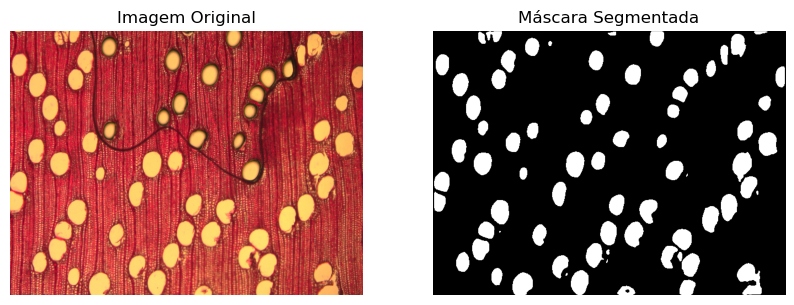

In [143]:
# Avaliação do modelo
model.eval() # 'model' is now assigned with the trained model.
with torch.no_grad():
    # 1. Carregar e preparar a imagem de teste
    test_image = cv2.imread("./Data/imagens/17.jpeg")
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)  # Converter BGR para RGB
    print(test_image.shape)
    # Calcular as novas dimensões que são múltiplos de 32
    h = (test_image.shape[0] // 32) * 8
    w = (test_image.shape[1] // 32) * 8
    # test_image = cv2.resize(test_image, IMG_SIZE)  # Redimensionar
    test_image = cv2.resize(test_image, (w, h))  # Redimensionar
    print(test_image.shape)

    # 2. Aplicar a transformação e adicionar dimensão de batch
    input_tensor = transform(test_image).unsqueeze(0).to(DEVICE) # Changed 'device' to 'DEVICE'

    # 3. Gerar a previsão
    output = model(input_tensor)
    predicted_mask = torch.sigmoid(output).squeeze().cpu().numpy()

    # 4. Binarizar a máscara
    binary_mask = (predicted_mask > 0.5).astype("uint8")
    # Converter binary_mask para tensor
    binary_mask = torch.tensor(binary_mask, dtype=torch.float32)

    # 5. Exibir a imagem original e a máscara
    plt.figure(figsize=(10, 5))

    # Imagem original
    plt.subplot(1, 2, 1)
    plt.imshow(test_image)
    plt.title("Imagem Original")
    plt.axis("off")

    # Máscara segmentada
    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask, cmap="gray")
    plt.title("Máscara Segmentada")
    plt.axis("off")

    plt.show()

['92.png', '91.png', '100.png', '98.png', '95.png', '93.png', '94.png', '99.png', '96.png', '97.png']
torch.Size([3, 224, 224]) torch.Size([1, 224, 224])


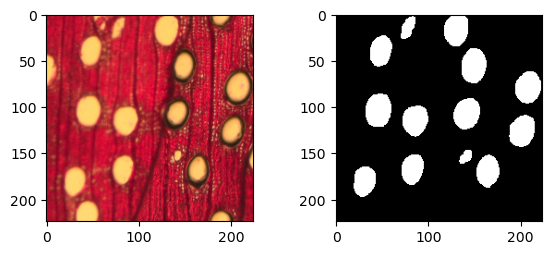

In [144]:
PATH_IMAGES = os.path.join(DATA_DIR, PATH_IMAGE)
PATH_LABELS = os.path.join(DATA_DIR, PATH_LABEL)

# print(PATH_IMAGES)
# print(PATH_LABELS)

mode='Test'

gen = SegmentationDataset(PATH_IMAGES, PATH_LABELS, mode='Test', transform=transform)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

r = 0  # Changed r to 0 to access the first and only element along the first dimension of y
image_size = y.shape[-1] # Get the image size from the shape of y

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(x.permute(1, 2, 0))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")  # Máscara em escala de cinza


